# **ETL y Análisis exploratorio de Datos (EDA)**

**Objetico:** Demostrar la limpieza y unificación de lo datos, e integrar métricas avanzadas (RFM y Producto) para generar un análidis exploratorio del negocio Aurelion.

### **Intregración de Metricas Avanzadas**

**Punto de partida** Cargamos el dataset `consolidado.csv` (resultado de la limpiezza ETL de las 4 tablas originales) e integramos los archivos de métricas pre-calculadas.

In [106]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import squarify
import warnings
warnings.filterwarnings('ignore') # Para ignorar warnings de matplotlib/seaborn

In [109]:
# Configuración de estilos para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [158]:
# Paleta extendida que combina los colores cálidos (rosa/violeta) y fríos (azul/verde)
extended_palette = sns.color_palette([
    # Tonos Rosas y Violetas Fuertes (Primavera)
    "#9932CC",  # Violeta Oscuro (Intenso)
    "#FF69B4",  # Rosa Fuerte (Hot Pink)
    "#C71585",  # Magenta Profundo
    
    # Tonos Azules y Verdes Fríos
    "#3CB371",  # Verde Menta Brillante
    "#4682B4",  # Azul Acero (Más profundo)
    "#00BFFF",  # Azul Cielo Brillante
    "#DA70D6",  # Orquídea Intensa (Puente)
])

print("Paleta extendida 'extended_palette' definida con 7 colores vibrantes.")

Paleta extendida 'extended_palette' definida con 7 colores vibrantes.


### **1. Carga del dataset consolidado.**

In [111]:
# Cargamos de nuevo el consolidado.csv para asegurar que no tenga columnas duplicadas de intentos anteriores.
try:
    df_final = pd.read_csv(os.path.join("./", "consolidado.csv"))
    df_final['fecha_venta'] = pd.to_datetime(df_final['fecha_venta'])
    print("Dataset 'consolidado.csv' cargando como df_final.")
except FileNotFoundError:
    print("Error: No se encontraron los archivos 'consolidado.csv'")

Dataset 'consolidado.csv' cargando como df_final.


### **2. Preparación e Integración de Métricas de Cliente (RFM).**

In [112]:
metricas_cliente = pd.read_csv(os.path.join("./", "metricas_cliente.csv"))

# **FIX:** Renombrar columnas de métricas de cliente ANTES del merge para evitar conflictos
metricas_cliente = metricas_cliente.rename(columns={
    'total_compras': 'total_compras_cliente',
    'importe_total': 'importe_total_cliente',
    'ticket_promedio': 'ticket_promedio_cliente',
    'frecuencia_compra': 'frecuencia_compra_cliente'
})

# Columnas finales de métricas de cliente para fusionar
cols_cliente = ['id_cliente', 'total_compras_cliente', 'importe_total_cliente', 
                'ticket_promedio_cliente', 'frecuencia_compra_cliente', 'productos_diferentes']
metricas_cliente = metricas_cliente[cols_cliente]

# Fusionar al DataFrame final (clave: id_cliente)
df_final = df_final.merge(metricas_cliente, on='id_cliente', how='left')
print(" Métricas de cliente añadidas (nombres corregidos con '_cliente').")

 Métricas de cliente añadidas (nombres corregidos con '_cliente').


### **3. PRE-PROCESAR E INTEGRAR MÉTRICAS DE PRODUCTO.**

In [114]:
metricas_producto_raw = pd.read_csv(os.path.join("./", "metricas_producto.csv"))

# Agregamos por nombre_producto para obtener los totales de vida del producto
metricas_producto = metricas_producto_raw.groupby('nombre_producto').agg(
    total_unidades_vendidas=('unidades_vendidas', 'sum'),
    importe_total_producto=('importe_total', 'sum')
).reset_index()

# Fusionar al DataFrame final (clave: nombre_producto)
cols_producto = ['nombre_producto', 'total_unidades_vendidas', 'importe_total_producto'] 
df_final = df_final.merge(metricas_producto[cols_producto], on='nombre_producto', how='left')
print(" Métricas de producto añadidas.")

# Columna de categoría final unificada
df_final['categoria_final'] = df_final['categoria_corregida'].fillna(df_final['nueva_categoria'])

# PREPARACIÓN PARA EL EDA AVANZADO (SECCIÓN 6)
# Definimos el DataFrame de clientes únicos con los nuevos nombres
df_clientes_unicos = df_final[['id_cliente', 'nombre_cliente', 'importe_total_cliente', 
                               'total_compras_cliente', 'ticket_promedio_cliente']].drop_duplicates(subset=['id_cliente']).copy()

print(f"\nDimensiones finales del dataset enriquecido: {df_final.shape}")

 Métricas de producto añadidas.

Dimensiones finales del dataset enriquecido: (343, 25)


## **Análisis Exploratorio de Datos (EDA)**

### I. Análisis de Clientes (RFM Básico)

### **1. Top 10 Clientes por Importe Total (Valor Monetario)**

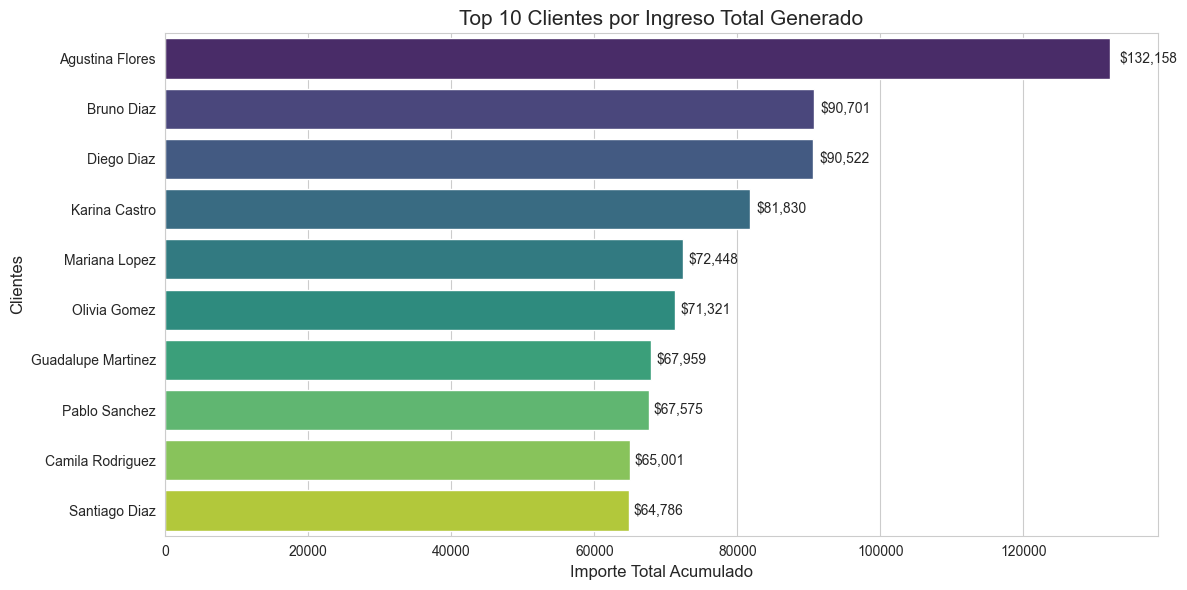

In [118]:
top_importe = df_clientes_unicos.sort_values(by='importe_total_cliente', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='importe_total_cliente', y='nombre_cliente', data=top_importe, palette='viridis')

plt.title('Top 10 Clientes por Ingreso Total Generado', fontsize=15)
plt.xlabel('Importe Total Acumulado', fontsize=12)
plt.ylabel('Clientes', fontsize=12)

# Agregar etiquetas de valores al final de cada barra
for index, value in enumerate(top_importe['importe_total_cliente']):
    plt.text(
        value + (value * 0.01),       # posición horizontal
        index,                        # posición vertical
        f"${value:,.0f}",             # formato con separación de miles
        va='center'
    )

plt.tight_layout()
plt.show()


### **2. Top 10 Clientes por Frecuencia de Compra.**


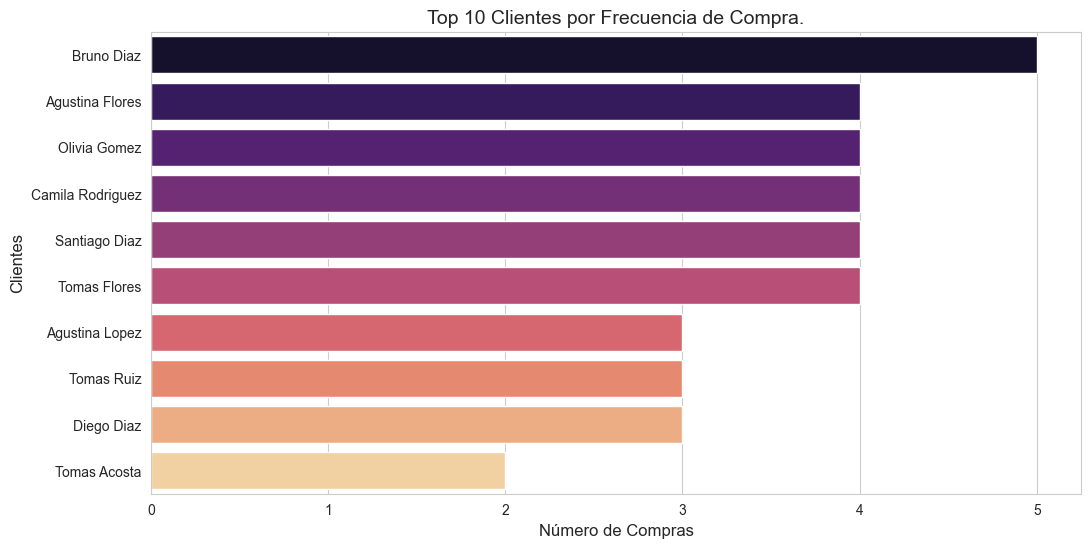

In [ ]:
top_frecuencia = df_clientes_unicos.sort_values(by='total_compras_cliente', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='total_compras_cliente', y='nombre_cliente', data=top_frecuencia, palette='magma')
plt.title('Top 10 Clientes por Frecuencia de Compra.')
plt.xlabel('Número de Compras')
plt.ylabel('Clientes')
plt.show()

### **3. Gráfico de Dispersión: Ticket Promedio & Importe Total.**

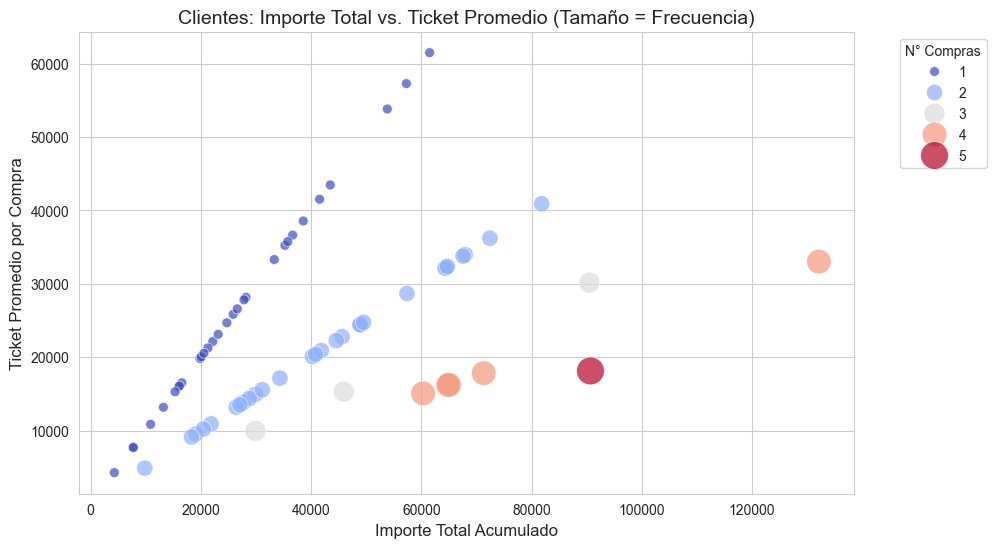

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='importe_total_cliente', y='ticket_promedio_cliente', data=df_clientes_unicos, 
                hue='total_compras_cliente', size='total_compras_cliente', 
                palette='coolwarm', sizes=(50, 400), alpha=0.7)
plt.title('Clientes: Importe Total vs. Ticket Promedio (Tamaño = Frecuencia)')
plt.xlabel('Importe Total Acumulado')
plt.ylabel('Ticket Promedio por Compra')
plt.legend(title='N° Compras', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

### **II. Análisis de Productos (Rentabilidad y Categorías)**

### **1. Top 5 Productos por Unidades Vendidas.**


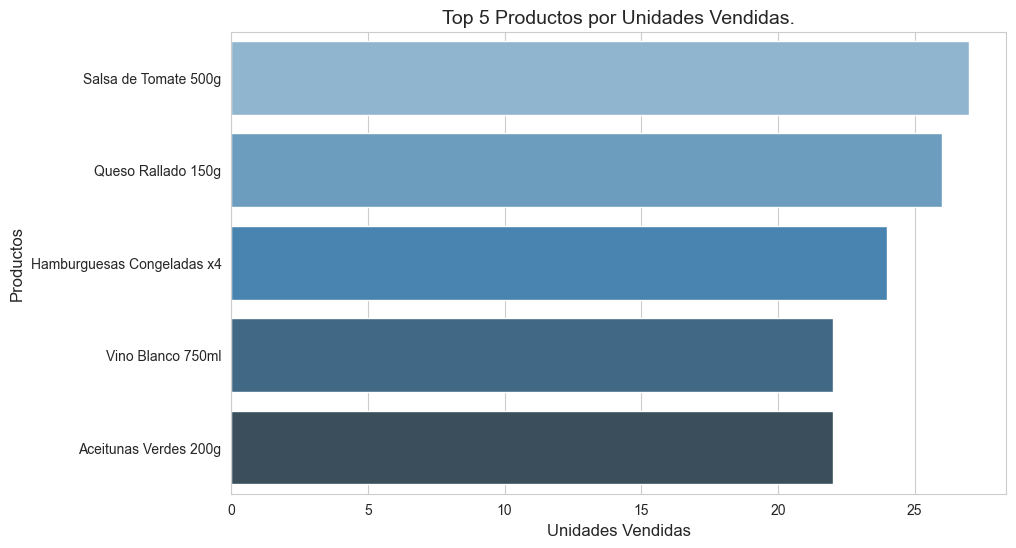

In [160]:
top_productos_volumen = df_final.groupby('nombre_producto').agg(
    total_unidades_vendidas=('cantidad', 'sum') 
).sort_values(by='total_unidades_vendidas', ascending=False).head(5).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='total_unidades_vendidas', y='nombre_producto', data=top_productos_volumen, palette='Blues_d')
plt.title('Top 5 Productos por Unidades Vendidas.')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Productos')
plt.show()

### **2. Distribución de Ingresos por Categoría Final**

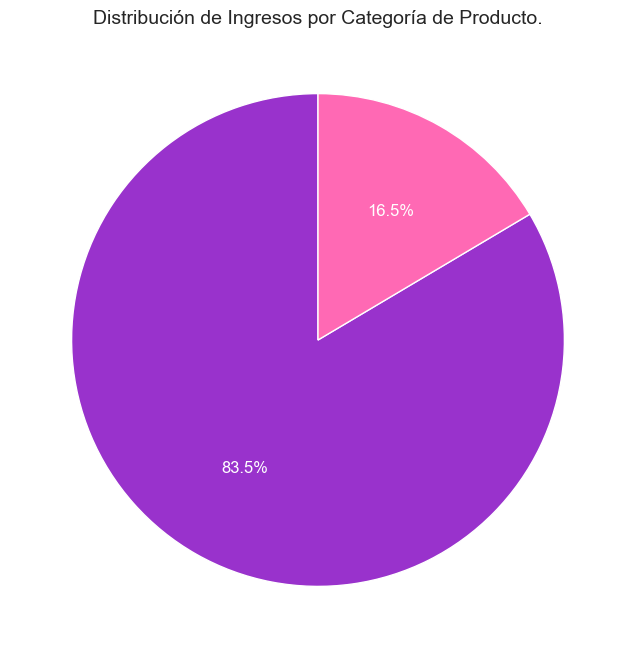

In [161]:
ingresos_categoria = df_final.groupby('categoria_final')['importe'].sum().reset_index()
ingresos_categoria = ingresos_categoria.sort_values(by='importe', ascending=False)

plt.figure(figsize=(8, 8))
plt.pie(ingresos_categoria['importe'], 
        labels=ingresos_categoria['categoria_final'],
        autopct='%1.1f%%', 
        startangle=90, 
        colors=strong_pink_violet, # Usamos la paleta fuerte
        textprops={'color': 'white', 'fontsize': 12}) # Aseguramos que el texto sea blanco

plt.title('Distribución de Ingresos por Categoría de Producto.')
plt.show()

### **3. Densidad de Unidades Vendidas - Top 5 Productos**

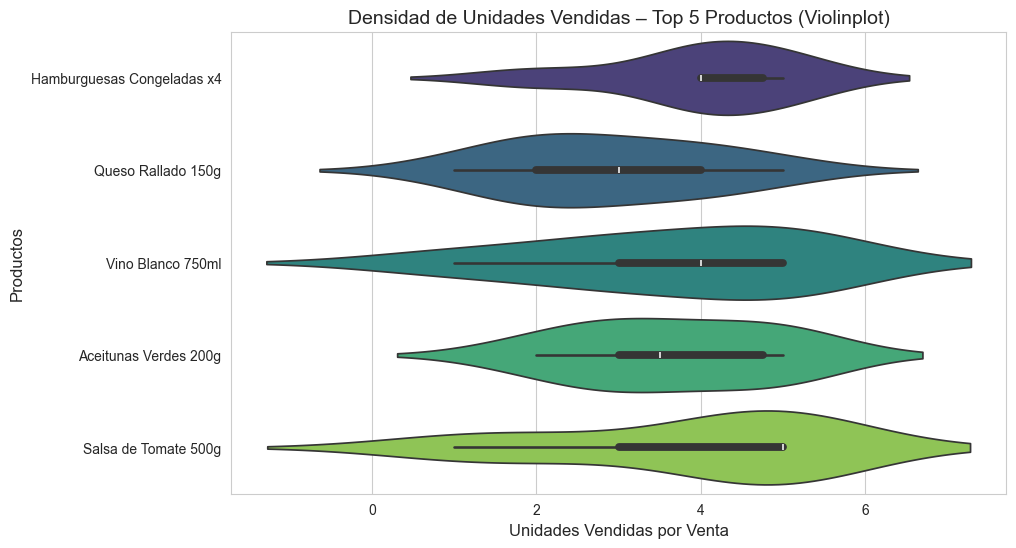

In [163]:
# Obtenemos la lista de los top 5 productos por nombre
top_5_nombres = top_productos_volumen['nombre_producto'].tolist()

# Filtrar el DataFrame final para incluir solo las transacciones de esos 5 productos
df_top_detalle = df_final[df_final['nombre_producto'].isin(top_5_nombres)].copy()

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_top_detalle,
    x='cantidad',
    y='nombre_producto',
    palette='viridis' #viridis o Blues
)

plt.title('Densidad de Unidades Vendidas – Top 5 Productos (Violinplot)')
plt.xlabel('Unidades Vendidas por Venta')
plt.ylabel('Productos')
plt.show()

### **III. Análisis Transaccional y Tendencias**

### **1. Histograma de la Distribución del Importe (Individual por línea de detalle)**

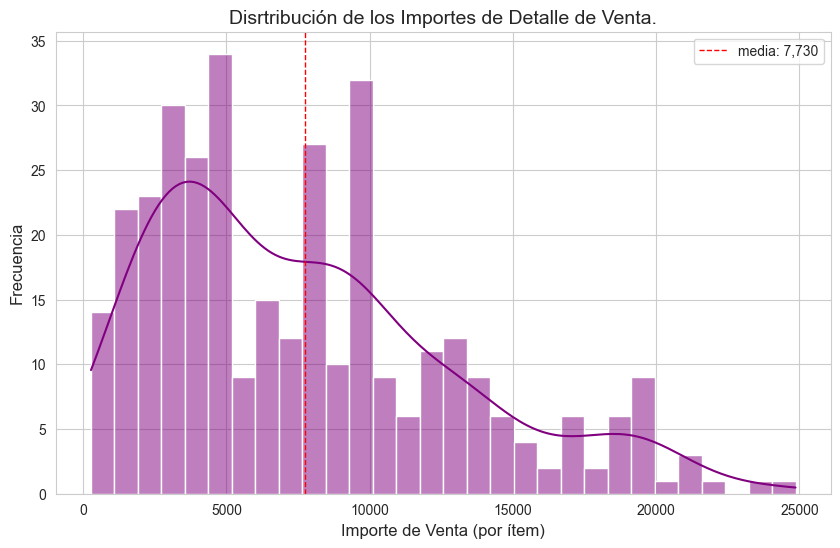

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['importe'], bins=30, kde=True, color='purple')
plt.title('Disrtribución de los Importes de Detalle de Venta.')
plt.xlabel('Importe de Venta (por ítem)')
plt.ylabel('Frecuencia')
plt.axvline(df_final['importe'].mean(),
            color='red', linestyle='dashed', linewidth=1,
            label=f'media: {df_final["importe"].mean():,.0f}')
plt.legend()
plt.show()


### **2. Frecuencia de Uso por Medio de Pago**

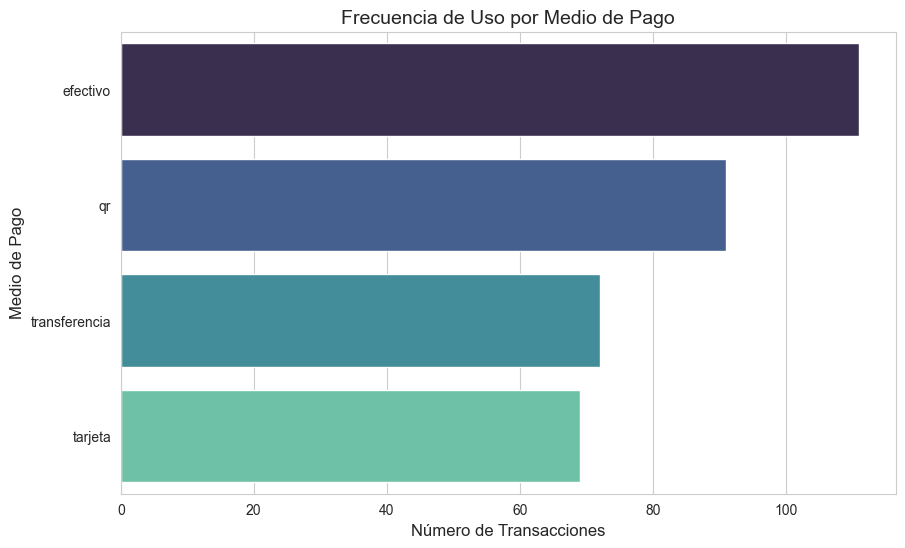

In [166]:
# %%
plt.figure(figsize=(10, 6))
sns.countplot(
    y='medio_pago', 
    data=df_final, 
    order=df_final['medio_pago'].value_counts().index, 
    palette='mako' # Reemplazado 'Spectral' por 'mako' (Gama de azules fríos)
)

plt.title('Frecuencia de Uso por Medio de Pago')
plt.xlabel('Número de Transacciones')
plt.ylabel('Medio de Pago')
plt.show()

### **3. Distribución del Importe por Medio de Pago**

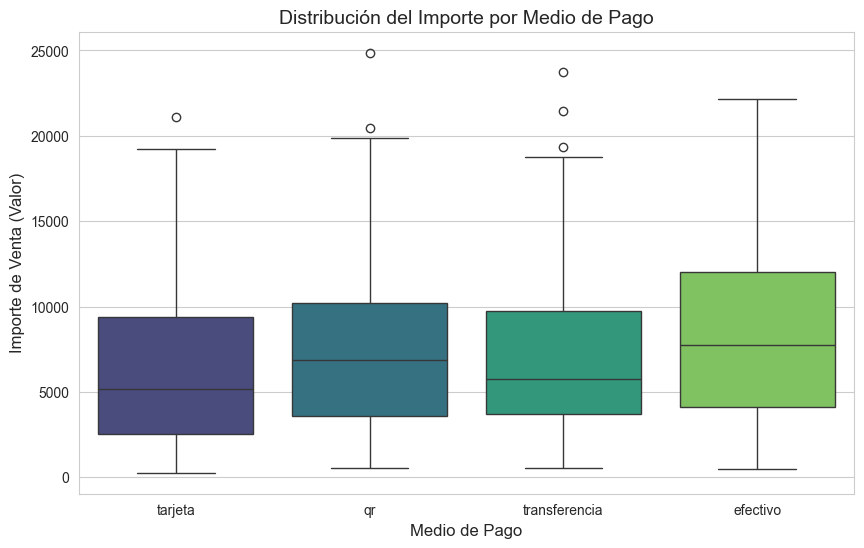

In [168]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_final,
    x='medio_pago',
    y='importe',
    palette='viridis' #Spectral
)

plt.title('Distribución del Importe por Medio de Pago')
plt.xlabel('Medio de Pago')
plt.ylabel('Importe de Venta (Valor)')
plt.show()

### **4. Tendencia de Ventas**
Visualizar el rendimiento total de ventas a través del tiempo para identificar estacionalidad o tendencias de crecimiento.

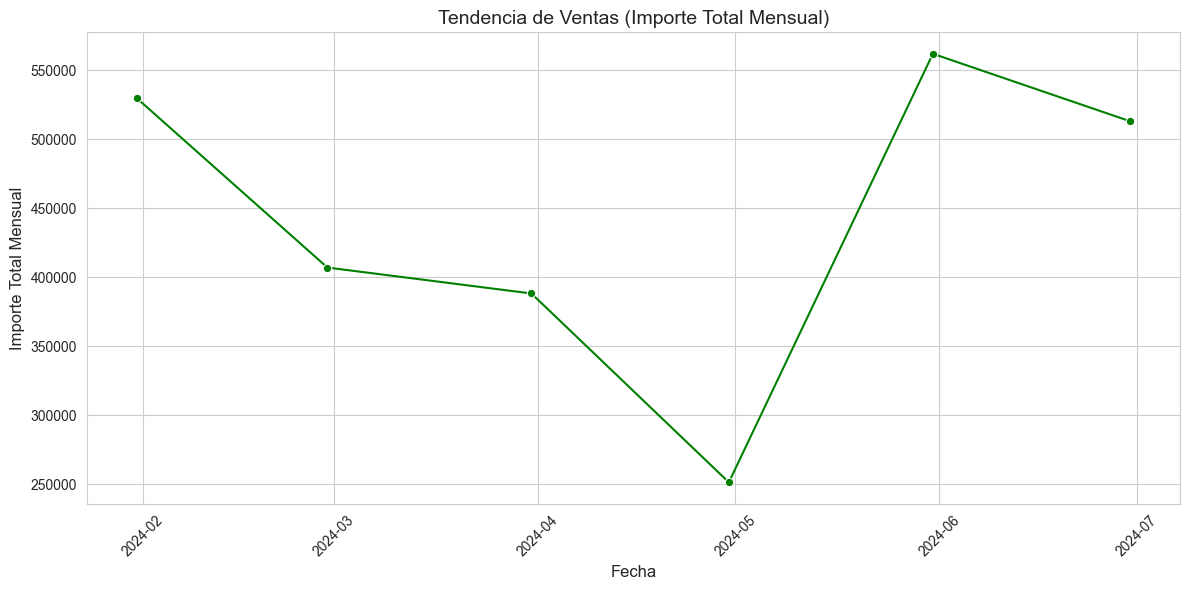

In [171]:
# Agrupar las ventas por fecha (o mes/año) y sumar el importe
df_tendencia = df_final.set_index('fecha_venta').resample('M')['importe'].sum().reset_index()

# Renombrar columna
df_tendencia.columns = ['fecha', 'importe_total']

plt.figure(figsize=(12, 6))
# Gráfico de línea para mostrar la evolución
sns.lineplot(x='fecha', y='importe_total', data=df_tendencia, marker='o', color='green')

plt.title('Tendencia de Ventas (Importe Total Mensual)')
plt.xlabel('Fecha')
plt.ylabel('Importe Total Mensual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **IV. Segmentación**

### **Gasto de Clientes Top 10 & Categoría**

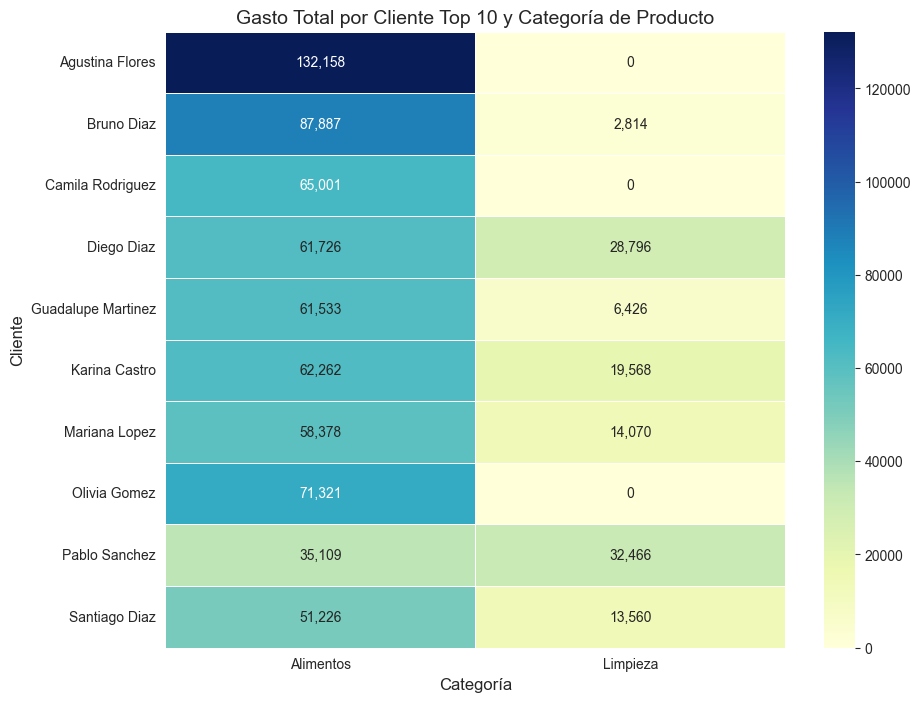

In [172]:
# Obtener la lista de nombres de los Top 10 clientes
top_10_nombres = df_clientes_unicos.sort_values(by='importe_total_cliente', ascending=False).head(10)['nombre_cliente'].tolist()

# Filtrar el DataFrame final
df_top_clientes = df_final[df_final['nombre_cliente'].isin(top_10_nombres)].copy()

# Pivotar la tabla: Cliente (Índice) vs. Categoría (Columnas) y Sumar el Importe
heatmap_data = df_top_clientes.pivot_table(
    index='nombre_cliente', 
    columns='categoria_final', 
    values='importe', 
    aggfunc='sum',
    fill_value=0
)
# Generar el Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=",.0f",
    cmap="YlGnBu", 
    linewidths=0.5, 
    linecolor='white'
)
plt.title('Gasto Total por Cliente Top 10 y Categoría de Producto')
plt.xlabel('Categoría')
plt.ylabel('Cliente')
plt.show()